# Importing packages

In [22]:
# Install the contractions package - https://github.com/kootenpv/contractions
!pip install contractions seaborn textblob scikit-learn-intelex optuna

In [23]:
!pip install transformers datasets evaluate

In [24]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
%matplotlib inline

# text preprocessing
import nltk
import re
import contractions
import string
from textblob import TextBlob # spelling correction

from sklearnex import patch_sklearn 
patch_sklearn()

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Model performance evaluation
import evaluate
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    classification_report,
)

# Hugging Face Dataset
from datasets import Dataset

# for tuning hyperparameters
import optuna

from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

# Modeling
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import LinearLR
from torch.nn.init import xavier_uniform_
from torch.utils.data import DataLoader

# Other useful
import math
import collections
import gc
from torch.types import Device
from prompt_toolkit import output

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
# for reproducibility
import random
seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Loading data and deleting rows with missing data

In [29]:
df = pd.read_csv(filepath_or_buffer='https://zenodo.org/record/4561253/files/WELFake_Dataset.csv?download=1', index_col=0)
# run next row with using jupiter lab
# df = pd.read_csv(filepath_or_buffer='WELFake_Dataset.csv', index_col=0)
df.shape

(72134, 3)

In [30]:
# we'll save it just in case
missed_texts = df[df.text.isnull()]
missed_titles = df[df.title.isnull()]
df = df.dropna()
df.shape

(71537, 3)

# Exploratory data analysis

## Exploring the data distributions

In [ ]:
real = df[df['label'] == 1]
fake = df[df['label'] == 0]
print(f'Real: {real.shape}\nFake: {fake.shape}')

Real: (36509, 3)
Fake: (35028, 3)


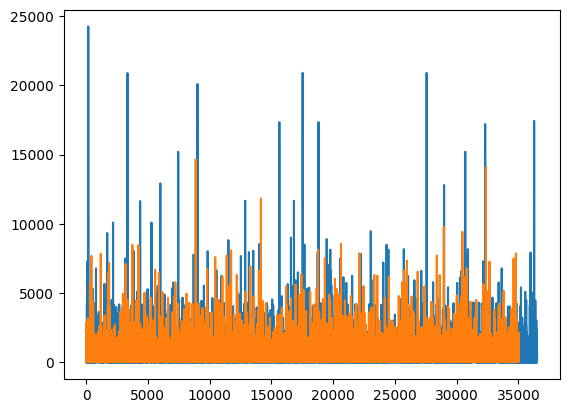

In [ ]:
plt.plot([len(txt.split()) for txt in real.text])
plt.plot([len(txt.split()) for txt in fake.text])

In [ ]:
print('Quantiles of the texts:')
print('\treal\tfake')
print(f'0.10 | {np.quantile([len(txt.split()) for txt in real.text], 0.10)}   | {np.quantile([len(txt.split()) for txt in fake.text], 0.10)}')
print(f'0.50 | {np.quantile([len(txt.split()) for txt in real.text], 0.50)}  | {np.quantile([len(txt.split()) for txt in fake.text], 0.50)}')
print(f'0.90 | {np.quantile([len(txt.split()) for txt in real.text], 0.90)}  | {np.quantile([len(txt.split()) for txt in fake.text], 0.90)}')
print(f'0.95 | {np.quantile([len(txt.split()) for txt in real.text], 0.95)} | {np.quantile([len(txt.split()) for txt in fake.text], 0.95)}')

Quantiles of the texts:
	real	fake
0.10 | 80.0   | 92.0
0.50 | 373.0  | 427.0
0.90 | 983.0  | 1181.0
0.95 | 1420.0 | 1419.0


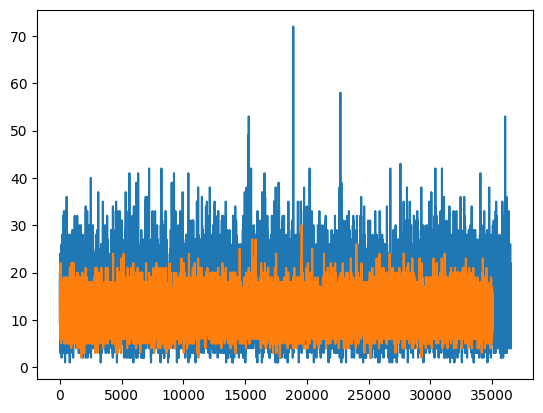

In [ ]:
plt.plot([len(txt.split()) for txt in real.title])
plt.plot([len(txt.split()) for txt in fake.title])

In [ ]:
print('Quantiles of the titles:')
print('\treal\tfake')
print(f'0.10 | {np.quantile([len(txt.split()) for txt in real.title], 0.10)}  | {np.quantile([len(txt.split()) for txt in fake.title], 0.10)}')
print(f'0.50 | {np.quantile([len(txt.split()) for txt in real.title], 0.50)} | {np.quantile([len(txt.split()) for txt in fake.title], 0.50)}')
print(f'0.90 | {np.quantile([len(txt.split()) for txt in real.title], 0.90)} | {np.quantile([len(txt.split()) for txt in fake.title], 0.90)}')
print(f'0.95 | {np.quantile([len(txt.split()) for txt in real.title], 0.95)} | {np.quantile([len(txt.split()) for txt in fake.title], 0.95)}')

Quantiles of the titles:
	real	fake
0.10 | 8.0  | 8.0
0.50 | 13.0 | 11.0
0.90 | 19.0 | 15.0
0.95 | 22.0 | 16.0


In [ ]:
# df = df[[len(txt.split()) for txt in df.text] <= np.quantile([len(txt.split()) for txt in real.text], 0.95)]

After analyzing the length distribution we can notice that fake news are generally longer than real news but their titles are shorter than real ones.

## Text cleaning

In [31]:
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)

def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text)

def remove_special_characters(text):
    """
        Remove special special characters, including symbols, emojis, and other graphic characters
    """
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_hashtag(text):
    return re.sub(r'#([^\s]+)', r'\1', text)# hashtag symbol

def remove_punct(text):
    """
        Remove the punctuation
    """
    return re.sub(r'[]!"$%&\'()*+,/:;=#@?[\\^_`{|}~-]+', "", text) # exclude a dot
#     return text.translate(str.maketrans('', '', string.punctuation)) # include a dot

def other_clean(text):
        """
            Other manual text cleaning techniques
        """
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }

        # Acronyms
        sample_acronyms =  { 
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",    
                            "gawx": "georgia weather",  
                            "scwx": "south carolina weather",  
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",  
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }

        
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u.s." : 'usa',
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }
            
        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        
        text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
        text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
        text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)
        
        return text
    
def remove_digits(text):
    """
        Remove the digits
    """
    return ''.join([i for i in text if not i.isdigit()])

def fix_spelling(text):
    return str(TextBlob(text).correct())
    
def fix_contractions(text):
    """
        Fix the contractions
    """
    return contractions.fix(text)

def transform_text(text):
    text = remove_URL(text)
    text = remove_html(text)
    text = remove_non_ascii(text)
    text = remove_special_characters(text)
    text = remove_hashtag(text)
    text = remove_punct(text)
    text = text.lower()
    text = other_clean(text)
    text = contractions.fix(text)
    text = text.lower()
    text = text.strip()
    return text

In [32]:
transform_text('Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements ain"t called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***ing ')

'members of the fyf911 or fukyoflag and blacklivesmatter movements are not called for the lynching and hanging of white people and cops. they encouraged others on a radio show tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in america.one of the fyoflag organizers is called  sunshine.  she has a radio blog show hosted from texas called  sunshine s fing'

In [33]:
df['text2'] = df.text.apply(transform_text)
df['title2'] = df.title.apply(transform_text)

In [34]:
for i in range(29, 100):
    print(df['text'].iloc[i])
    print('-----------------')
    print(df['text2'].iloc[i])
    break

HARARE (Reuters) - Zimbabwe President Robert Mugabe arrived at a university graduation ceremony in the capital on Friday, his first public appearance since a military seizure of power that political sources say is aimed at ending his 37 years in office. Wearing a blue and yellow academic gown and mortar board hat, the 93-year-old sat in large wooden chair at the front the hall. He was greeted by ululations from the crowd as he declared the ceremony open. 
-----------------
harare reuters  zimbabwe president robert mugabe arrived at a university graduation ceremony in the capital on friday his first public appearance since a military seizure of power that political sources say is aimed at ending his 37 years in office. wearing a blue and yellow academic gown and mortar board hat the 93yearold sat in large wooden chair at the front the hall. he was greeted by ululations from the crowd as he declared the ceremony open.


# Classification using only the title

## Splitting the dataset

In [ ]:
df_X, df_y = df['title'], df['label']
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.15, random_state=42, shuffle=True)

print('\t\t X   |   y')
print(f'Train:      {X_train.shape} | {y_train.shape}')
print(f'Test:       {X_test.shape} | {y_test.shape}')
print()
print('\t\t\treal   | fake')
print(f'Train:      {sum(y_train==1)/len(y_train)} | {sum(y_train==0)/len(y_train)}')
print(f'Test:       {sum(y_test==1)/len(y_test)} | {sum(y_test==1)/len(y_test)}')

		 X   |   y
Train:      (60806,) | (60806,)
Test:       (10731,) | (10731,)

			real   | fake
Train:      0.5114955760944644 | 0.4885044239055356
Test:       0.5038673003447954 | 0.5038673003447954


## Vectorization

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

print('\t\t     X     |   y')
print(f'Train:      {X_train.shape} | {y_train.shape}')
print(f'Test:       {X_test.shape} | {y_test.shape}')

		     X     |   y
Train:      (60806, 29204) | (60806,)
Test:       (10731, 29204) | (10731,)


## Evaluating

In [ ]:
def plot_conf_matrix(y_test, y_preds):
    cm = confusion_matrix(y_test, y_preds)
    class_names=[0, 1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_roc_auc(y_test, y_pred):
    lr_auc = roc_auc_score(y_test, y_preds)
    print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
    # рассчитываем roc-кривую
    fpr, tpr, treshold = roc_curve(y_test, y_preds)
    roc_auc = auc(fpr, tpr)
    # строим график
    plt.plot(fpr, tpr, color='darkorange',
            label='ROC кривая (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc="lower right")
    plt.show()

def castom_evaluate(y_test, y_preds):
    plot_conf_matrix(y_test, y_preds)
    plot_roc_auc(y_test, y_preds)
    print(classification_report(y_test, y_preds))
    print(f'Accuracy: {accuracy_score(y_test, y_preds)}')
    print(f'Accuracy: {f1_score(y_test, y_preds)}')

## Logistic Regression

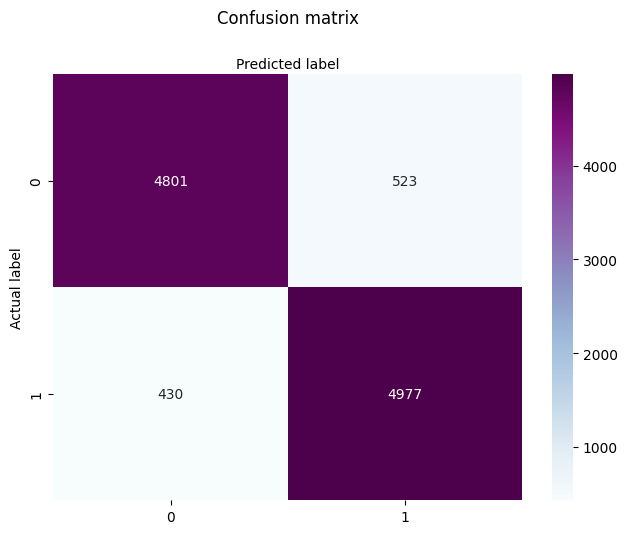

LogisticRegression: ROC AUC=0.911


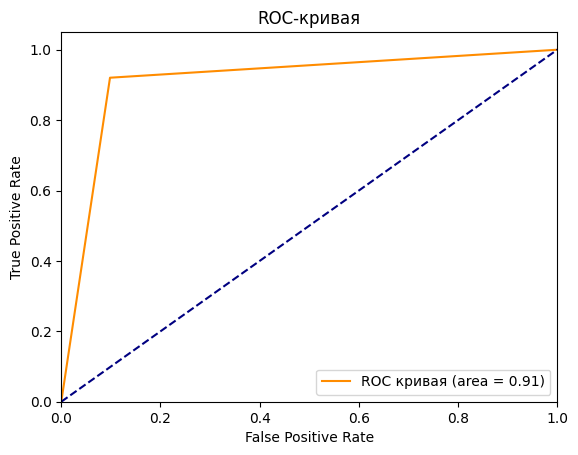

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      5324
           1       0.90      0.92      0.91      5407

    accuracy                           0.91     10731
   macro avg       0.91      0.91      0.91     10731
weighted avg       0.91      0.91      0.91     10731

Accuracy: 0.9111918740098779
Accuracy: 0.9126249197762903


In [ ]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
castom_evaluate(y_test, y_preds)

In [ ]:
param_distributions = {
    'penalty': optuna.distributions.CategoricalDistribution(['l1', 'l2']),
    'C': optuna.distributions.FloatDistribution(1e-2, 1e5, log=True),
    'solver': optuna.distributions.CategoricalDistribution(['liblinear', 'saga']),
}

In [ ]:
optuna_search = optuna.integration.OptunaSearchCV(lr, param_distributions, random_state=42)
optuna_search.fit(X_train, y_train)

In [ ]:
y_preds = optuna_search.best_estimator_.predict(X_test)

Text(0.5, 427.9555555555555, 'Predicted label')

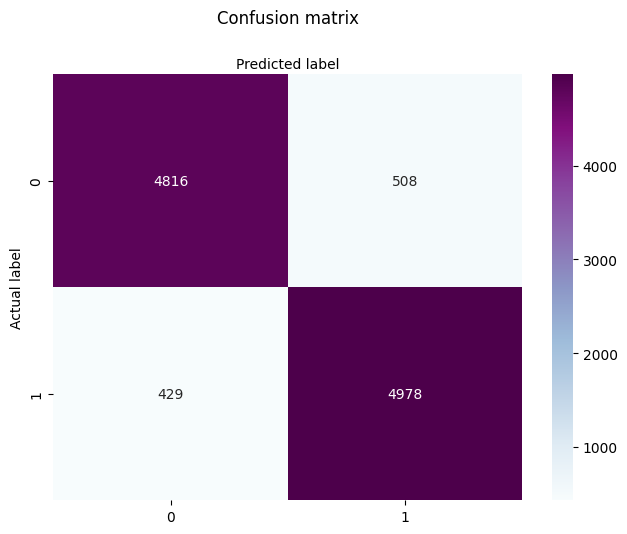

In [ ]:
cm = confusion_matrix(y_test,y_preds)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

LogisticRegression: ROC AUC=0.913


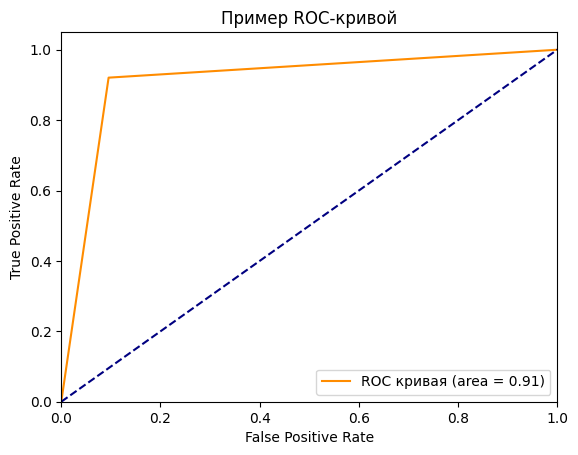

In [ ]:
lr_auc = roc_auc_score(y_test, y_preds)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      5324
           1       0.91      0.92      0.91      5407

    accuracy                           0.91     10731
   macro avg       0.91      0.91      0.91     10731
weighted avg       0.91      0.91      0.91     10731



In [ ]:
print(f'Accuracy: {accuracy_score(y_test, y_preds)}')
print(f'Accuracy: {f1_score(y_test, y_preds)}')

Accuracy: 0.9126828813717268
Accuracy: 0.9139814559809052


## Random Forest

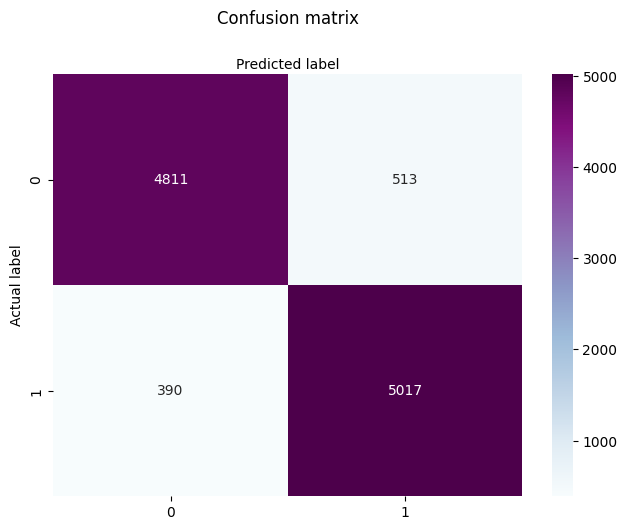

LogisticRegression: ROC AUC=0.916


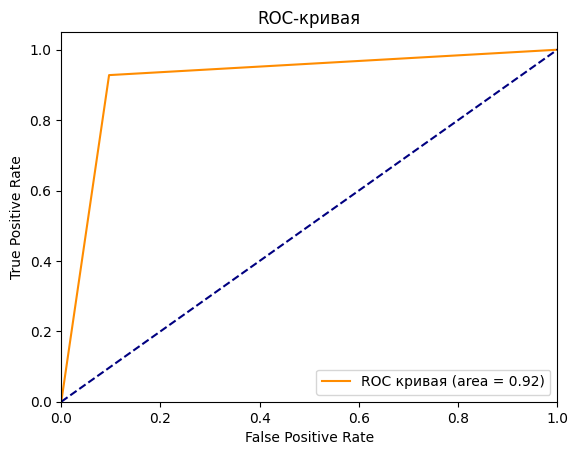

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      5324
           1       0.91      0.93      0.92      5407

    accuracy                           0.92     10731
   macro avg       0.92      0.92      0.92     10731
weighted avg       0.92      0.92      0.92     10731

Accuracy: 0.9158512720156555
Accuracy: 0.91743622565603


In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_preds = rfc.predict(X_test)
castom_evaluate(y_test, y_preds)

In [ ]:
param_distributions = {
    'n_estimators': optuna.distributions.IntDistribution(10, 1000, log=True),
    'criterion': optuna.distributions.CategoricalDistribution(["gini", "entropy", "log_loss"]),
    'max_depth': optuna.distributions.IntDistribution(4, 20),
    'n_jobs': optuna.distributions.IntDistribution(-1, -1),
}

In [ ]:
optuna_search = optuna.integration.OptunaSearchCV(rfc, param_distributions, random_state=42)
optuna_search.fit(X_train, y_train)

C:\Users\Home\AppData\Local\Temp\ipykernel_15936\4265121687.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(rfc, param_distributions, random_state=42)
[I 2023-04-06 21:57:10,904] A new study created in memory with name: no-name-56efdda1-1575-4edb-b26e-4cfe054baa78
[I 2023-04-06 21:57:17,789] Trial 0 finished with value: 0.8303292119985166 and parameters: {'n_estimators': 79, 'criterion': 'gini', 'max_depth': 12, 'n_jobs': -1}. Best is trial 0 with value: 0.8303292119985166.
[I 2023-04-06 21:57:20,405] Trial 1 finished with value: 0.7965823009847826 and parameters: {'n_estimators': 38, 'criterion': 'gini', 'max_depth': 9, 'n_jobs': -1}. Best is trial 0 with value: 0.8303292119985166.
[I 2023-04-06 21:57:23,493] Trial 2 finished with value: 0.8054300412079393 and parameters: {'n_estimators': 48, 'criterion': 'gini', 'max_depth': 10, 'n_jobs': -1}. Best is trial 

OptunaSearchCV(estimator=RandomForestClassifier(),
               param_distributions={'criterion': CategoricalDistribution(choices=('gini', 'entropy', 'log_loss')),
                                    'max_depth': IntDistribution(high=20, log=False, low=4, step=1),
                                    'n_estimators': IntDistribution(high=1000, log=True, low=10, step=1),
                                    'n_jobs': IntDistribution(high=-1, log=False, low=-1, step=1)},
               random_state=42)

In [ ]:
y_preds = optuna_search.best_estimator_.predict(X_test)

In [ ]:
optuna_search.best_params_

{'n_estimators': 106, 'criterion': 'log_loss', 'max_depth': 19, 'n_jobs': -1}

Text(0.5, 427.9555555555555, 'Predicted label')

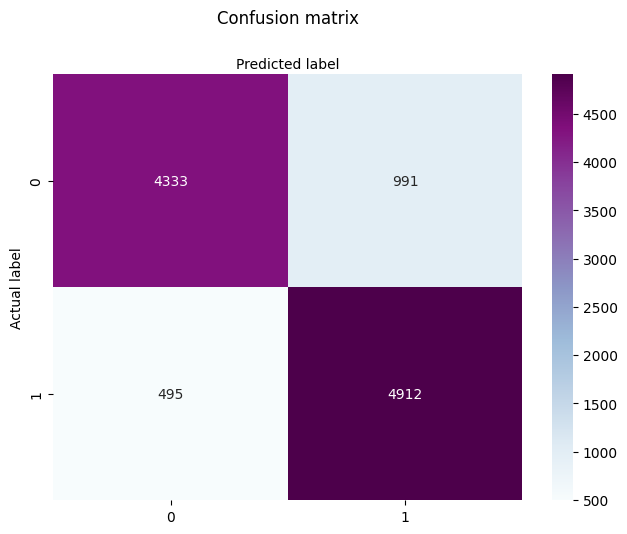

In [ ]:
cm = confusion_matrix(y_test,y_preds)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

LogisticRegression: ROC AUC=0.861


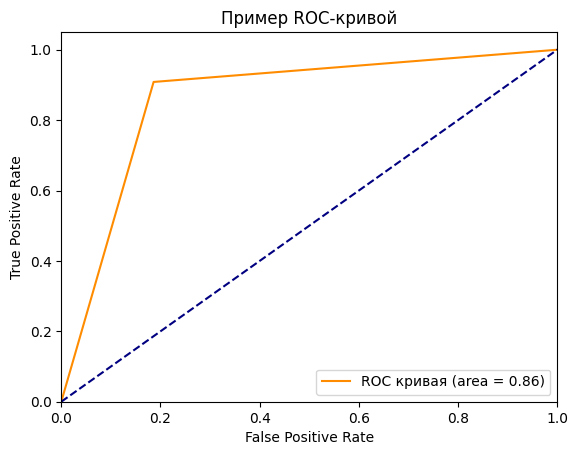

In [ ]:
lr_auc = roc_auc_score(y_test, y_preds)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(classification_report(y_test, y_preds))
print(f'Accuracy: {accuracy_score(y_test, y_preds)}')
print(f'Accuracy: {f1_score(y_test, y_preds)}')

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      5324
           1       0.83      0.91      0.87      5407

    accuracy                           0.86     10731
   macro avg       0.86      0.86      0.86     10731
weighted avg       0.86      0.86      0.86     10731

Accuracy: 0.8615226912682882
Accuracy: 0.8686118479221927


## SVM

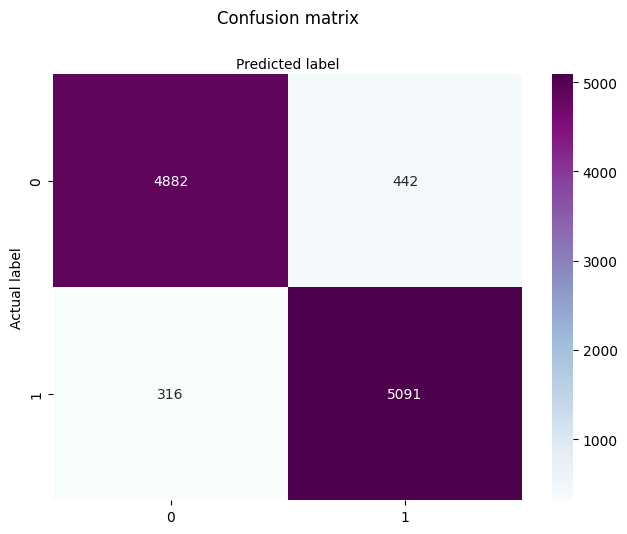

LogisticRegression: ROC AUC=0.929


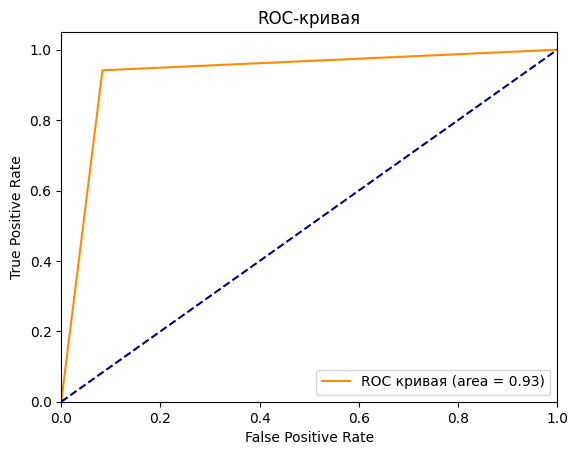

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      5324
           1       0.92      0.94      0.93      5407

    accuracy                           0.93     10731
   macro avg       0.93      0.93      0.93     10731
weighted avg       0.93      0.93      0.93     10731

Accuracy: 0.9293635262324108
Accuracy: 0.9307129798903109


In [ ]:
svm = SVC(random_state=42)
svm.fit(X_train, y_train)
y_preds = svm.predict(X_test)
castom_evaluate(y_test, y_preds)

In [ ]:
param_distributions = {
    'C': optuna.distributions.IntDistribution(1e-2, 1e5),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
}

In [ ]:
optuna_search = optuna.integration.OptunaSearchCV(svm, param_distributions, random_state=42)
optuna_search.fit(X_train, y_train)

C:\Users\Home\AppData\Local\Temp\ipykernel_15936\2415828084.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(svm, param_distributions, random_state=42)
[I 2023-04-07 06:36:42,337] A new study created in memory with name: no-name-924162e8-8dc5-4288-b81b-5d61ebe61cf9
[I 2023-04-07 07:05:18,296] Trial 0 finished with value: 0.859372396123538 and parameters: {'C': 45470, 'kernel': 'linear'}. Best is trial 0 with value: 0.859372396123538.
[I 2023-04-07 07:32:56,510] Trial 1 finished with value: 0.8664276355487679 and parameters: {'C': 29826, 'kernel': 'sigmoid'}. Best is trial 1 with value: 0.8664276355487679.


In [ ]:
y_preds = optuna_search.best_estimator_.predict(X_test)

In [ ]:
optuna_search.best_params_

In [ ]:
cm = confusion_matrix(y_test,y_preds)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
lr_auc = roc_auc_score(y_test, y_preds)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(classification_report(y_test, y_preds))
print(f'Accuracy: {accuracy_score(y_test, y_preds)}')
print(f'Accuracy: {f1_score(y_test, y_preds)}')

## LSTM

In [35]:
df_ = df[['title', 'label']]
data_train, data_test = train_test_split(df_, test_size=0.15, random_state=42, shuffle=True)

print('\t\t Shape')
print(f'Train:      {data_train.shape}')
print(f'Test:       {data_test.shape}')
print()
print('\t\t\treal   | fake')
print(f"Train:      {sum(data_train['label']==1)/len(data_train)} | {sum(data_train['label']==0)/len(data_train)}")
print(f"Test:       {sum(data_test['label']==1)/len(data_test)} | {sum(data_test['label']==1)/len(data_test)}")

		 Shape
Train:      (60806, 2)
Test:       (10731, 2)

			real   | fake
Train:      0.5114955760944644 | 0.4885044239055356
Test:       0.5038673003447954 | 0.5038673003447954


In [36]:
data_train, data_val = train_test_split(data_train, test_size=0.15, random_state=42, shuffle=True)

print('\t\t Shape')
print(f'Train:      {data_train.shape}')
print(f'Test:       {data_val.shape}')
print()
print('\t\t\treal   | fake')
print(f"Train:      {sum(data_train['label']==1)/len(data_train)} | {sum(data_train['label']==0)/len(data_train)}")
print(f"Test:       {sum(data_val['label']==1)/len(data_val)} | {sum(data_val['label']==1)/len(data_val)}")

		 Shape
Train:      (51685, 2)
Test:       (9121, 2)

			real   | fake
Train:      0.5119473735126245 | 0.48805262648737546
Test:       0.5089354237473961 | 0.5089354237473961


In [37]:
tokenizer = get_tokenizer('basic_english')

def build_vocabulary(datasets):
  for dataset in datasets:
    for text in dataset['title']:
      yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([data_train, data_val]), specials=['<UNK>'])
vocab.set_default_index(vocab['<UNK>'])

In [38]:
print(f'Vocabulary length: {vocab.__len__()}')

Vocabulary length: 44177


In [39]:
# PARAMETERS

# for data_loader
MAX_WORDS  = 22
BATCH_SIZE = 1024

# for model
EMBED_LEN     = 50
HIDDEN_DIM    = 75
N_LAYERS      = 3
TRAIN_ON_GPU  = torch.cuda.is_available()
EPOCHS        = 5
LR            = 1e-2
BIDIRECTIONAL = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# for saving checkpoints
# PATH = Path('checkpoints_lstm')
# PATH.mkdir(exist_ok=True)

In [149]:
train_dataset, val_dataset, test_dataset = to_map_style_dataset(data_train.values), \
                                           to_map_style_dataset(data_val.values), \
                                           to_map_style_dataset(data_test.values), \

def vectorize_batch(batch):
    X, Y = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X] # tokenize and map tokens to indexes
    X = [tokens+([0]*(MAX_WORDS - len(tokens))) if len(tokens) < MAX_WORDS else tokens[:MAX_WORDS] for tokens in X]
    return torch.tensor(X, dtype=torch.int32, device=device), torch.tensor(Y, device=device)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)

In [ ]:
target_classes = [0, 1]


class LSTMClassifier(nn.Module):
  def __init__(self):
    super(LSTMClassifier, self).__init__()

    self.num_directions = (2 if BIDIRECTIONAL else 1)

    self.emb_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
    self.lstm = nn.LSTM(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS, dropout=0.5, batch_first=True, bidirectional=BIDIRECTIONAL)
    self.fc = nn.Linear(in_features=HIDDEN_DIM*self.num_directions, out_features=len(target_classes))
    self.softmax = nn.LogSoftmax(dim=1)

  def init_hidden(self, batch_size):
    '''Initializes hidden state'''
    # Create two new tensors with sizes n_layers x batch_size x n_hidden,
    # initialized to zero, for hidden state and cell state of LSTM
    weight = next(self.parameters()).data
    
    if (TRAIN_ON_GPU):
      hidden = (xavier_uniform_(weight.new(self.num_directions*N_LAYERS, batch_size, HIDDEN_DIM)).cuda(),
                xavier_uniform_(weight.new(self.num_directions*N_LAYERS, batch_size, HIDDEN_DIM)).cuda())
    else:
      hidden = (xavier_uniform_(weight.new(self.num_directions*N_LAYERS, batch_size, HIDDEN_DIM)),
                xavier_uniform_(weight.new(self.num_directions*N_LAYERS, batch_size, HIDDEN_DIM)))
    return hidden

  def forward(self, X_batch, hidden):
    emb = self.emb_layer(X_batch)
    output, hidden = self.lstm(emb, hidden)
    output = self.fc(output[:, -1])
    output = self.softmax(output)
    return output, hidden

In [ ]:
lstm_classifier = LSTMClassifier()

lstm_classifier

LSTMClassifier(
  (emb_layer): Embedding(44177, 50)
  (lstm): LSTM(50, 75, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=150, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
for layer in lstm_classifier.children():
  print(f'Layer: {layer}')
  print('Parameters: ')
  for param in layer.parameters():
    print(param.shape)
  print()

Layer: Embedding(44177, 50)
Parameters: 
torch.Size([44177, 50])

Layer: LSTM(50, 75, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
Parameters: 
torch.Size([300, 50])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 50])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 150])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 150])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 150])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 150])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])

Layer: Linear(in_features=150, out_features=2, bias=True)
Parameters: 
torch.Size([2, 150])
torch.Size([2])

Layer: LogSoftmax(dim=1)
Parameters: 



In [150]:
def CalcValLossAndAccuracy(model, loss_fn, val_loader):
  with torch.no_grad():
    Y_shuffled, Y_preds, losses = [], [], []
    for X, Y in val_loader:

      # initialise hidden state
      h = model.init_hidden(X.shape[0])

      preds, h = model(X, h)
      loss = loss_fn(preds, Y)
      losses.append(loss.item())

      Y_shuffled.append(Y)
      Y_preds.append(preds.argmax(dim=-1))

    Y_shuffled = torch.cat(Y_shuffled)
    Y_preds = torch.cat(Y_preds)

    valid_loss = torch.tensor(losses).cpu().mean()
    valid_acc = accuracy_score(Y_shuffled.cpu().detach().numpy(), Y_preds.cpu().detach().numpy())

    print(f'Valid Loss: {valid_loss:.3f}')
    print(f'Valid Acc : {valid_acc:.3f}')

    return valid_loss, valid_acc


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, device, epochs=10):
  train_losses, val_losses, val_accs = [], [], []
  for i in range(1, epochs+1):
    losses = []
    for X, Y in tqdm(train_loader):
      X.to(device)
      Y.to(device)
      model.to(device)

    #   initialise hidden state
      h = model.init_hidden(X.shape[0])

      Y_preds, h = model(X, h)

      loss = loss_fn(Y_preds, Y)
      losses.append(loss.item())

      optimizer.zero_grad()

      loss.backward()
      optimizer.step()

    train_loss = torch.tensor(losses).mean()
    print(f'Train Loss: {train_loss:.3f}')
    valid_loss, valid_acc = CalcValLossAndAccuracy(model, loss_fn, val_loader)

    # save the best model
    # save_best_model(valid_loss, i, model, optimizer, loss_fn, path)

    # append losses and accuracy to lists
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)

  # save the trained model weights for a final time
#   save_model(i, model, optimizer, loss_fn, path)
  # save the loss and accuracy plots
#   save_plots(val_accs, train_losses, val_losses, path)

In [ ]:
OPT     = Adam(lstm_classifier.parameters(), lr=LR, weight_decay=5e-5)
LOSS_FN = nn.CrossEntropyLoss()
MODEL   = lstm_classifier

TrainModel(model=MODEL, loss_fn=LOSS_FN, optimizer=OPT, train_loader=train_loader, val_loader=val_loader, device=device, epochs=EPOCHS)

  0%|          | 0/51 [00:00<?, ?it/s]

Train Loss: 0.492
Valid Loss: 0.350
Valid Acc : 0.864


  0%|          | 0/51 [00:00<?, ?it/s]

Train Loss: 0.257
Valid Loss: 0.256
Valid Acc : 0.899


  0%|          | 0/51 [00:00<?, ?it/s]

Train Loss: 0.202
Valid Loss: 0.220
Valid Acc : 0.912


  0%|          | 0/51 [00:00<?, ?it/s]

Train Loss: 0.164
Valid Loss: 0.217
Valid Acc : 0.915


  0%|          | 0/51 [00:00<?, ?it/s]

Train Loss: 0.142
Valid Loss: 0.202
Valid Acc : 0.922


In [ ]:
MODEL.eval()

def MakePredictions(model, loader, device):
  Y_shuffled, Y_preds= [], []
  for X, Y in loader:
    X.to(device)
    Y.to(device)
    # initialize hidden state
    h = model.init_hidden(X.shape[0])
    preds, h = model(X, h)
    Y_preds.append(preds)
    Y_shuffled.append(Y)
  gc.collect()
  Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

  return Y_shuffled.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1)

Y_actual, Y_preds = MakePredictions(MODEL, test_loader, device)
Y_actual, Y_preds = torch.tensor(Y_actual).cpu(), torch.tensor(Y_preds).cpu()

<ipython-input-121-332cb8dcc577>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_actual, Y_preds = torch.tensor(Y_actual).cpu(), torch.tensor(Y_preds).cpu()


In [ ]:
target_classes = ['fake', 'real']
print(f'Test Accuracy: {accuracy_score(Y_actual, Y_preds)}')
print('\nClassification report: ')
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print('\nConfusion Matrix: ')
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy: 0.9256360078277887

Classification report: 
              precision    recall  f1-score   support

        fake       0.93      0.92      0.92      5324
        real       0.92      0.93      0.93      5407

    accuracy                           0.93     10731
   macro avg       0.93      0.93      0.93     10731
weighted avg       0.93      0.93      0.93     10731


Confusion Matrix: 
[[4908  416]
 [ 382 5025]]


## Transformer

In [ ]:
# PARAMETERS
MAX_WORDS  = 40
BATCH_SIZE = 1024
EPOCHS     = 15
LR         = 1e-2
# PATH       = Path('checkpoints_simple_transformer')

EMBED_LEN  = 50
HEADS      = 1
DEPTH      = 6

# PATH.mkdir(exist_ok=True)

In [ ]:
df_ = df[['title', 'label']]
data_train, data_test = train_test_split(df_, test_size=0.15, random_state=42, shuffle=True)

print('\t\t Shape')
print(f'Train:      {data_train.shape}')
print(f'Test:       {data_test.shape}')
print()
print('\t\t\treal   | fake')
print(f"Train:      {sum(data_train['label']==1)/len(data_train)} | {sum(data_train['label']==0)/len(data_train)}")
print(f"Test:       {sum(data_test['label']==1)/len(data_test)} | {sum(data_test['label']==1)/len(data_test)}")

data_train, data_val = train_test_split(data_train, test_size=0.15, random_state=42, shuffle=True)

print('\t\t Shape')
print(f'Train:      {data_train.shape}')
print(f'Validation:       {data_val.shape}')
print()
print('\t\t\treal   | fake')
print(f"Train:      {sum(data_train['label']==1)/len(data_train)} | {sum(data_train['label']==0)/len(data_train)}")
print(f"Validation:       {sum(data_val['label']==1)/len(data_val)} | {sum(data_val['label']==1)/len(data_val)}")

		 Shape
Train:      (60806, 2)
Test:       (10731, 2)

			real   | fake
Train:      0.5114955760944644 | 0.4885044239055356
Test:       0.5038673003447954 | 0.5038673003447954
		 Shape
Train:      (51685, 2)
Validation:       (9121, 2)

			real   | fake
Train:      0.5119473735126245 | 0.48805262648737546
Validation:       0.5089354237473961 | 0.5089354237473961


In [ ]:
class ClsTransformer(nn.Module):
    """
    Transformer for classifying sequences
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes, max_pool=True, dropout=0.0):
        """
        :param emb: Embedding dimension
        :param heads: nr. of attention heads
        :param depth: Number of transformer blocks
        :param seq_length: Expected maximum sequence length
        :param num_tokens: Number of tokens (usually words) in the vocabulary
        :param num_classes: Number of classes.
        :param max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()
        self.num_tokens, self.max_pool = num_tokens, max_pool
        self.token_embedding = nn.Embedding(num_embeddings=num_tokens, embedding_dim=emb)
        self.pos_embedding = nn.Embedding(num_embeddings=seq_length, embedding_dim=emb)
        self.unify_embeddings = nn.Linear(2 * emb, emb)

        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, dropout=dropout))
            
        self.tblocks = nn.Sequential(*tblocks)
        self.toprobs = nn.Linear(emb, num_classes)
        self.do = nn.Dropout(dropout)

    def forward(self, x):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        tokens = self.token_embedding(x)
        b, t, e = tokens.size()
        positions = self.pos_embedding(torch.arange(t, device=device))[None, :, :].expand(b, t, e)
        x = self.unify_embeddings(torch.cat((tokens, positions), dim=2).view(-1, 2 * e)).view(b, t, e)
        x = self.do(x)
        x = self.tblocks(x)
        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1) # pool over the time dimension
        x = self.toprobs(x)
        return F.log_softmax(x, dim=1)


class SelfAttention(nn.Module):
    def __init__(self, emb, heads=8):
        """
        :param emb:
        :param heads:
        :param mask:
        """
        super().__init__()

        self.emb = emb
        self.heads = heads

        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)

        self.unifyheads = nn.Linear(heads * emb, emb)

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

        keys    = self.tokeys(x)   .view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x) .view(b, t, h, e)

        # compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys    = keys   .transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values  = values .transpose(1, 2).contiguous().view(b * h, t, e)

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))
        dot = dot / math.sqrt(e) # dot contains b*h  t-by-t matrices with raw self-attention logits

        assert dot.size() == (b*h, t, t), f'Matrix has size {dot.size()}, expected {(b*h, t, t)}.'

        dot = F.softmax(dot, dim=2) # dot now has row-wise self-attention probabilities

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, e)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * e)

        return self.unifyheads(out)


class TransformerBlock(nn.Module):
    def __init__(self, emb, heads, seq_length, ff_hidden_mult=5, dropout=0.4):
        super().__init__()
        self.attention = SelfAttention(emb, heads=heads)
        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)
        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb),
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb),
        )
        self.do = nn.Dropout(dropout)

    def forward(self, x):
        attended = self.attention(x)
        x = self.norm1(attended + x)
        x = self.do(x)
        feedforward = self.ff(x)
        x = self.norm2(feedforward + x)
        x = self.do(x)
        return x       

In [ ]:
MODEL   = ClsTransformer(
                emb=EMBED_LEN,
                heads=HEADS,
                depth=DEPTH,
                seq_length=MAX_WORDS, 
                num_tokens=len(vocab),
                num_classes=2
            )
OPT     = AdamW(MODEL.parameters(), lr=LR, weight_decay=5e-2)
LR_SCHD = LinearLR(OPT, total_iters=(EPOCHS * len(train_loader)))
LOSS_FN = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    # Training
    train_losses, val_losses, val_accs = [], [], []
    MODEL.train()
    for X, Y in tqdm(train_loader):
        X, Y, MODEL = X.to(device), Y.to(device), MODEL.to(device)

        Y_preds = MODEL(X)

        loss = LOSS_FN(Y_preds, Y)
        train_losses.append(loss)

        OPT.zero_grad()

        loss.backward()
        OPT.step()
    train_loss = torch.tensor(train_losses).mean()
    print(f'Train Loss: {train_loss:.3f}')

    # Evaluation
    MODEL.eval()
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [], [], []
        for X, Y in tqdm(val_loader):
            preds = MODEL(X)
            loss = LOSS_FN(preds, Y)
            losses.append(loss)

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds    = torch.cat(Y_preds)

        valid_loss = torch.tensor(losses).to(device).mean()
        valid_acc  = accuracy_score(
                        Y_shuffled.cpu().detach().numpy(),
                        Y_preds.cpu().detach().numpy()
                        )
        print(f'Valid Loss: {valid_loss:.3f}')
        print(f'Epoch: {epoch}, Valid Acc : {valid_acc:.3f}')
    
    LR_SCHD.step()

    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)

  0%|          | 0/51 [00:00<?, ?it/s]

# Splitting data

In [ ]:
df_X, df_y = df.drop(columns=['label']), df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.1, random_state=42, shuffle=True)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
print(f'Train:      {X_train.shape} | {y_train.shape}')
print(f'Validation: {X_val.shape} | {y_val.shape}')
print(f'Test:       {X_test.shape}  | {y_test.shape}')

Train:      (51506, 4) | (51506,)
Validation: (12877, 4) | (12877,)
Test:       (7154, 4)  | (7154,)


In [ ]:
print('\t\t\treal   | fake')
print(f'Train:      {sum(y_train==1)/len(y_train)} | {sum(y_train==0)/len(y_train)}')
print(f'Validation: {sum(y_val==1)/len(y_val)} | {sum(y_val==1)/len(y_val)}')
print(f'Test:       {sum(y_test==1)/len(y_test)}    | {sum(y_test==1)/len(y_test)}')

			real   | fake
Train:      0.5110860870578185 | 0.4889139129421815
Validation: 0.5119981362118506 | 0.5119981362118506
Test:       0.5020967291026    | 0.5020967291026


In [ ]:
def tfidf_vectorize(data):
    new_data = data[['text2', 'title2']]
    vectorizer = TfidfVectorizer()
    text2 = vectorizer.fit_transform(new_data['text2'])
    title2 = vectorizer.fit_transform(new_data['title2'])
    return hstack([text2, title2])

def tfidf_vectorize_all(train, val, test):
    new_train = train[['text2', 'title2']]
    new_val = val[['text2', 'title2']]
    new_test = test[['text2', 'title2']]
    vectorizer_text = TfidfVectorizer()
    vectorizer_title = TfidfVectorizer()
    
    train_text2 = vectorizer_text.fit_transform(new_train['text2'])
    train_title2 = vectorizer_title.fit_transform(new_train['title2'])
    
    val_text2 = vectorizer_text.transform(new_val['text2'])
    val_title2 = vectorizer_title.transform(new_val['title2'])
    
    test_text2 = vectorizer_text.transform(new_test['text2'])
    test_title2 = vectorizer_title.transform(new_test['title2'])
    
    return (
        hstack([train_text2, train_title2]),
        hstack([val_text2, val_title2]),
        hstack([test_text2, test_title2])
    )

In [ ]:
X_train, X_val, X_test = tfidf_vectorize_all(X_train, X_val, X_test)
print(f'Train:      {X_train.shape}')
print(f'Validation: {X_val.shape}')
print(f'Test:       {X_test.shape}')

Train:      (51506, 278717)
Validation: (12877, 278717)
Test:       (7154, 278717)


In [ ]:
class CustomTfidfVectorizer(TfidfVectorizer):
    def __init__(self):
        super().__init__()

    def fit_transform(self, X, y):
        new_X = X[['text2', 'title2']]
        vectorizer = TfidfVectorizer()
        vectorized_text = super().fit_transform(new_X['text2'])
        vectorized_title = super().fit_transform(new_X['title2'])
        result = pd.DataFrame({'text2': np.array(vectorized_text),
                               'title2': np.array(vectorized_title)})
        return result

In [ ]:
np.concatenate([np.zeros((10, 5)), np.zeros((10, 5))], axis=1)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
pipe_svm = Pipeline(
    [
        ('vectorizer', CustomTfidfVectorizer()),
        ('classifier', SVC())
    ]
)

pipe_svm.fit(X_train[:100], y_train[:100])

In [ ]:
svm = SVC(verbose=True)

In [ ]:
svm.fit(X_train, y_train)

SVC(verbose=True)

In [ ]:
y_preds = svm.predict(X_test)
y_preds.shape

(7154,)

Text(0.5, 427.9555555555555, 'Predicted label')

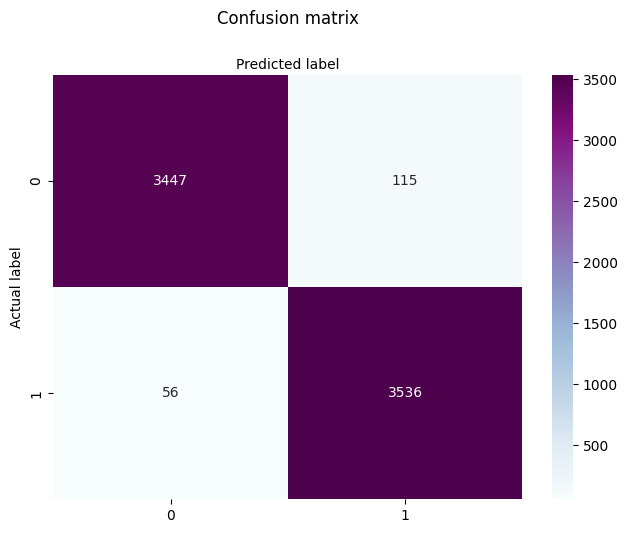

In [ ]:
cm = confusion_matrix(y_test,y_preds)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3562
           1       0.97      0.98      0.98      3592

    accuracy                           0.98      7154
   macro avg       0.98      0.98      0.98      7154
weighted avg       0.98      0.98      0.98      7154



# test


In [ ]:
def tfidf_vectorize_all_ver2(train, val, test):
    new_train = train[['text2', 'title2']]
    new_val = val[['text2', 'title2']]
    new_test = test[['text2', 'title2']]
    vectorizer_text1 = TfidfVectorizer()
    vectorizer_title1 = TfidfVectorizer()
    
    train_text2 = vectorizer_text1.fit_transform(new_train['text2'])
    train_title2 = vectorizer_title1.fit_transform(new_train['title2'])

    vectorizer_text2 = TfidfVectorizer(vocabulary=vectorizer_text1.vocabulary_)
    vectorizer_title2 = TfidfVectorizer(vocabulary=vectorizer_title1.vocabulary_)

    val_text2 = vectorizer_text2.fit_transform(new_val['text2'])
    val_title2 = vectorizer_title2.fit_transform(new_val['title2'])
    
    test_text2 = vectorizer_text2.fit_transform(new_test['text2'])
    test_title2 = vectorizer_title2.fit_transform(new_test['title2'])
    
    return (
        hstack([train_text2, train_title2]),
        hstack([val_text2, val_title2]),
        hstack([test_text2, test_title2])
    )

In [ ]:
X_train, X_val, X_test = tfidf_vectorize_all_ver2(X_train, X_val, X_test)
print(f'Train:      {X_train.shape}')
print(f'Validation: {X_val.shape}')
print(f'Test:       {X_test.shape}')

Train:      (51506, 278717)
Validation: (12877, 278717)
Test:       (7154, 278717)


In [ ]:
svm = SVC(verbose=True)

In [ ]:
svm.fit(X_train, y_train)

SVC(verbose=True)

In [ ]:
y_preds = svm.predict(X_test)
y_preds.shape

(7154,)

Text(0.5, 427.9555555555555, 'Predicted label')

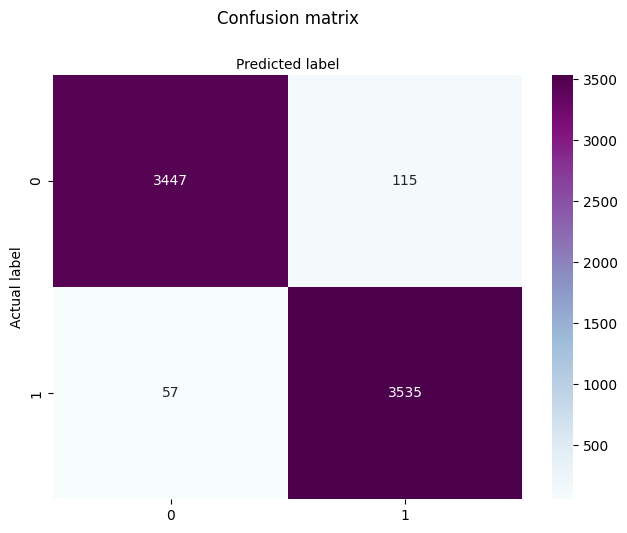

In [ ]:
cm = confusion_matrix(y_test,y_preds)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3562
           1       0.97      0.98      0.98      3592

    accuracy                           0.98      7154
   macro avg       0.98      0.98      0.98      7154
weighted avg       0.98      0.98      0.98      7154



In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
accuracy_score(y_test,y_preds)

0.9759575062901873

In [ ]:
f1_score(y_test,y_preds)

0.976249654791494

# test 2

In [ ]:
df_X, df_y = df.drop(columns=['label']), df['label']

In [ ]:
vectorizer_text_ = TfidfVectorizer()
vectorizer_title_ = TfidfVectorizer()
text2_ = vectorizer_text_.fit_transform(df_X['text2'])
title2_ = vectorizer_title_.fit_transform(df_X['title2'])
df_X_ = hstack([text2_, title2_])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_X_, df_y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
print(f'Train:      {X_train.shape} | {y_train.shape}')
print(f'Validation: {X_val.shape} | {y_val.shape}')
print(f'Test:       {X_test.shape}  | {y_test.shape}')

Train:      (51506, 325098) | (51506,)
Validation: (12877, 325098) | (12877,)
Test:       (7154, 325098)  | (7154,)


In [ ]:
svm_ = SVC(verbose=True)

In [ ]:
svm_.fit(X_train, y_train)

SVC(verbose=True)

In [ ]:
y_preds = svm_.predict(X_val)
y_preds.shape

(12877,)

In [ ]:
accuracy_score(y_val,y_preds)

0.9742952551060029

In [ ]:
f1_score(y_val,y_preds)

0.9751221345358887

Text(0.5, 427.9555555555555, 'Predicted label')

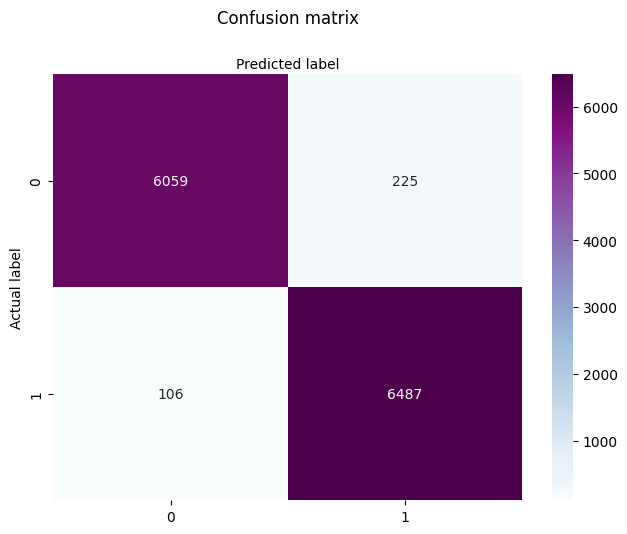

In [ ]:
cm = confusion_matrix(y_val,y_preds)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier()

In [ ]:
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_preds = rfc.predict(X_val)

Text(0.5, 427.9555555555555, 'Predicted label')

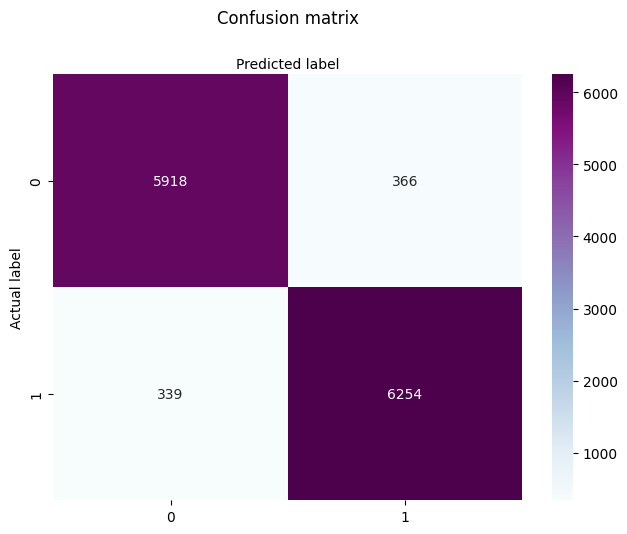

In [ ]:
cm = confusion_matrix(y_val,y_preds)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      6284
           1       0.94      0.95      0.95      6593

    accuracy                           0.95     12877
   macro avg       0.95      0.95      0.95     12877
weighted avg       0.95      0.95      0.95     12877



In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_preds = lr.predict(X_val)

Text(0.5, 427.9555555555555, 'Predicted label')

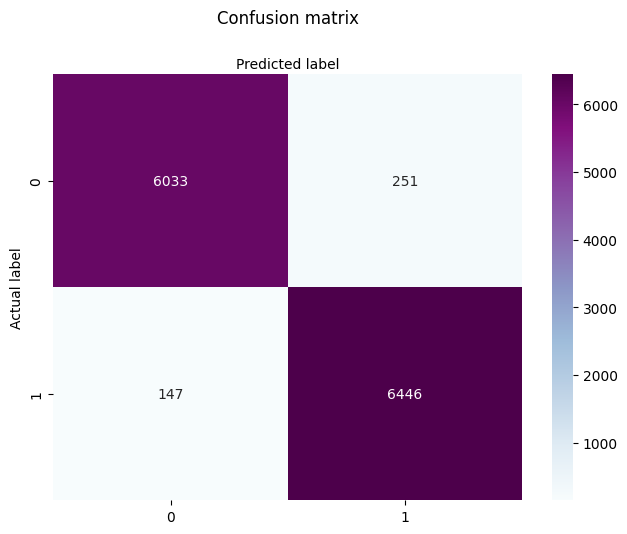

In [ ]:
cm = confusion_matrix(y_val,y_preds)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6284
           1       0.96      0.98      0.97      6593

    accuracy                           0.97     12877
   macro avg       0.97      0.97      0.97     12877
weighted avg       0.97      0.97      0.97     12877



In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

In [ ]:
lr = LogisticRegression()

In [ ]:
param_distributions = {
    'penalty': optuna.distributions.CategoricalDistribution(['l1', 'l2']),
    # 'tol': optuna.distributions.FloatDistribution(1e-5, 1e-3, log=True),
    'C': optuna.distributions.FloatDistribution(1e-10, 1e10, log=True),
    'solver': optuna.distributions.CategoricalDistribution(['liblinear', 'saga']),
    # 'random_state': optuna.distributions.IntDistribution(42, 42),
    # 'max_iter': optuna.distributions.IntDistribution(50, 150, step=10),
}

In [ ]:
optuna_search = optuna.integration.OptunaSearchCV(lr, param_distributions, random_state=42)

<ipython-input-22-a617f72bf59a>:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(lr, param_distributions, random_state=42)


In [ ]:
optuna_search.fit(X_train, y_train)

[I 2023-04-06 10:10:19,713] A new study created in memory with name: no-name-25574041-488f-4f27-a223-ee7ecc48516a
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-04-06 10

OptunaSearchCV(estimator=LogisticRegression(),
               param_distributions={'C': FloatDistribution(high=10000000000.0, log=True, low=1e-10, step=None),
                                    'penalty': CategoricalDistribution(choices=('l1', 'l2')),
                                    'random_state': IntDistribution(high=42, log=False, low=42, step=1),
                                    'solver': CategoricalDistribution(choices=('liblinear', 'saga'))},
               random_state=42)

In [ ]:
y_preds = optuna_search.best_estimator_.predict(X_test)

Text(0.5, 427.9555555555555, 'Predicted label')

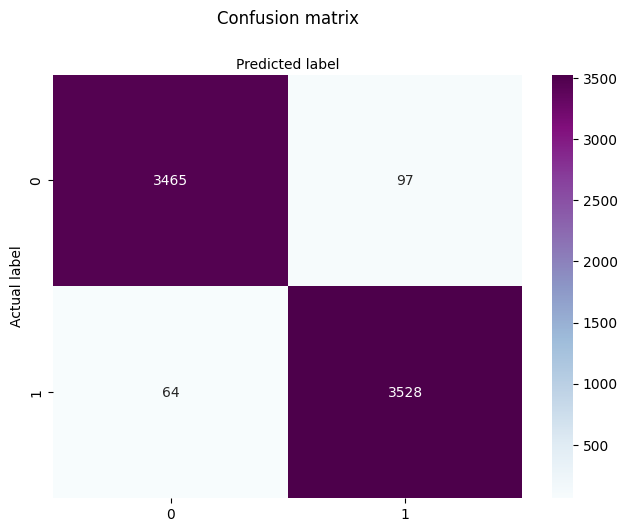

In [ ]:
cm = confusion_matrix(y_test,y_preds)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3562
           1       0.97      0.98      0.98      3592

    accuracy                           0.98      7154
   macro avg       0.98      0.98      0.98      7154
weighted avg       0.98      0.98      0.98      7154



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [ ]:
accuracy_score(y_test, y_preds)

0.9774951076320939

In [ ]:
f1_score(y_test, y_preds)

0.9776915615906886

In [ ]:
roc_auc_score(y_test, y_preds)

0.9774753679334824

In [ ]:
df_X, df_y = df['title'], df['label']

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
df_X = tfidf_vectorizer.fit_transform

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# test 3

In [ ]:
# PARAMETERS
CHECKPOINT = "bert-base-uncased"

BATCH_SIZE = 128
NUM_EPOCHS = 5
LR         = 3e-5

In [ ]:
df_ = df[['title', 'label']]
data_train, data_test = train_test_split(df_, test_size=0.15, random_state=42, shuffle=True)

print('\t\t Shape')
print(f'Train:      {data_train.shape}')
print(f'Test:       {data_test.shape}')
print()
print('\t\t\treal   | fake')
print(f"Train:      {sum(data_train['label']==1)/len(data_train)} | {sum(data_train['label']==0)/len(data_train)}")
print(f"Test:       {sum(data_test['label']==1)/len(data_test)} | {sum(data_test['label']==1)/len(data_test)}")

data_train, data_val = train_test_split(data_train, test_size=0.15, random_state=42, shuffle=True)

print('\t\t Shape')
print(f'Train:      {data_train.shape}')
print(f'Validation:       {data_val.shape}')
print()
print('\t\t\treal   | fake')
print(f"Train:      {sum(data_train['label']==1)/len(data_train)} | {sum(data_train['label']==0)/len(data_train)}")
print(f"Validation:       {sum(data_val['label']==1)/len(data_val)} | {sum(data_val['label']==1)/len(data_val)}")

In [ ]:
# Convert pandas dataframe to Hugging Face arrow dataset
hg_train_data = Dataset.from_pandas(data_train)
hg_val_data = Dataset.from_pandas(data_val)
hg_test_data = Dataset.from_pandas(data_test)

print(hg_train_data)
print(hg_val_data)
print(hg_test_data)

In [ ]:
# Tokenizer from a pretrained model
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)

# Take a look at the tokenizer
tokenizer

In [ ]:
# Mapping between special tokens and their IDs.
print(f'The unknown token is {tokenizer.unk_token} and the ID for the unknown token is {tokenizer.unk_token_id}.')
print(f'The seperator token is {tokenizer.sep_token} and the ID for the seperator token is {tokenizer.sep_token_id}.')
print(f'The pad token is {tokenizer.pad_token} and the ID for the pad token is {tokenizer.pad_token_id}.')
print(f'The sentence level classification token is {tokenizer.cls_token} and the ID for the classification token is {tokenizer.cls_token_id}.')
print(f'The mask token is {tokenizer.mask_token} and the ID for the mask token is {tokenizer.mask_token_id}.')

In [ ]:
# Funtion to tokenize data
def tokenize_function(data):
    return tokenizer(data["title"],
                     max_length=22,
                     truncation=True)

# Tokenize the dataset
dataset_train = hg_train_data.map(tokenize_function, batched=True)
dataset_val   = hg_val_data  .map(tokenize_function, batched=True)
dataset_test  = hg_test_data .map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Take a look at the data
print(dataset_train)
print(dataset_val)
print(dataset_test)

In [ ]:
# Remove the review and index columns because it will not be used in the model
dataset_train = dataset_train.remove_columns(["title", "__index_level_0__"])
dataset_val   = dataset_val  .remove_columns(["title", "__index_level_0__"])
dataset_test  = dataset_test .remove_columns(["title", "__index_level_0__"])
dataset_subm  = dataset_subm .remove_columns(["title"])

# Rename label to labels because the model expects the name labels
dataset_train = dataset_train.rename_column("label", "labels")
dataset_val   = dataset_val  .rename_column("label", "labels")
dataset_test  = dataset_test .rename_column("label", "labels")

# Change the format to PyTorch tensors
dataset_train.set_format("torch")
dataset_val  .set_format("torch")
dataset_test .set_format("torch")

# Take a look at the data
print(dataset_train)
print(dataset_val)
print(dataset_test)

In [ ]:
# Empty cache
torch.cuda.empty_cache()

# DataLoader
train_dataloader = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, collate_fn=data_collator,  shuffle=True)
val_dataloader   = DataLoader(dataset=dataset_val,   batch_size=BATCH_SIZE, collate_fn=data_collator)
test_dataloader  = DataLoader(dataset=dataset_test,  batch_size=BATCH_SIZE, collate_fn=data_collator)

In [ ]:
# inspect the batch
for batch in train_dataloader:
  break
{k: v.shape for k, v in batch.items()}

In [ ]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=2)
# model.to(device)

In [ ]:
# pass one batch to this model to make sure that everything is ok
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

In [ ]:
# Number of training steps
num_training_steps = NUM_EPOCHS * len(train_dataloader)

# Optimizer
optimizer = AdamW(params=model.parameters(), lr=LR)

# Set up the learning rate scheduler
lr_scheduler = get_scheduler(name="linear", 
                             optimizer=optimizer, 
                             num_warmup_steps=0, 
                             num_training_steps=num_training_steps)

print(f'Number of the training steps: {num_training_steps}')

In [ ]:
# Use GPU if it is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print(device)

In [ ]:
recall_metric    = evaluate.load('recall')
precision_metric = evaluate.load('precision')
f1_metric        = evaluate.load('f1')
accuracy_metric  = evaluate.load('accuracy')

# Set the progress bar
progress_bar = tqdm(range(num_training_steps))

best_accuracy = 0
prec_list_to_plot = []
rec_list_to_plot  = []
f1_list_to_plot   = []
acc_list_to_plot  = []

# Loop through the epochs
for epoch in range(1, NUM_EPOCHS + 1):
    # Tells the model that we are training the model
    model.train()
    # Loop through the batches
    for batch in train_dataloader:
        # Get the batch
        batch = {k: v.to(device) for k, v in batch.items()}
        # Compute the model output for the batch
        outputs = model(**batch)
        # Loss computed by the model
        loss = outputs.loss
        # backpropagates the error to calculate gradients
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Learning rate scheduler
        lr_scheduler.step()
        # Clear the gradients
        optimizer.zero_grad()
        # Update the progress bar
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
          outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        recall_metric   .add_batch(predictions=predictions, references=batch['labels'])
        precision_metric.add_batch(predictions=predictions, references=batch['labels'])
        f1_metric       .add_batch(predictions=predictions, references=batch['labels'])
        accuracy_metric .add_batch(predictions=predictions, references=batch['labels'])
    
    results = {
        'recall':    recall_metric   .compute(average='weighted'),
        'precision': precision_metric.compute(average='weighted'),
        'f1':        f1_metric       .compute(average='weighted'),
        'accuracy':  accuracy_metric .compute()
    }
    
    print(
        f'Epoch: {epoch}:',
        {
            key: value
            for key, value in results.items()
        },
    )

    prec_list_to_plot.append(results['recall'])
    rec_list_to_plot .append(results['precision'])
    f1_list_to_plot  .append(results['f1'])
    acc_list_to_plot .append(results['accuracy']['accuracy'])

    if results['accuracy']['accuracy'] > best_accuracy:
        best_accuracy = results['accuracy']['accuracy']
        model.save_pretrained('best_model')
    
model.save_pretrained('final_model')

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    acc_list_to_plot, color='blue',
    linestyle='-', label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')

In [ ]:
progress_bar = tqdm(range(len(test_dataloader)))

# Evaluation
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
        
    recall_metric   .add_batch(predictions=predictions, references=batch['labels'])
    precision_metric.add_batch(predictions=predictions, references=batch['labels'])
    f1_metric       .add_batch(predictions=predictions, references=batch['labels'])
    accuracy_metric .add_batch(predictions=predictions, references=batch['labels'])
    progress_bar.update(1)
    
results = {
        'recall':    recall_metric   .compute(average='weighted'),
        'precision': precision_metric.compute(average='weighted'),
        'f1':        f1_metric       .compute(average='weighted'),
        'accuracy':  accuracy_metric .compute(),
    }
    
print(
        {
            key: value
            for key, value in results.items()
        },
    )

# test 4

In [41]:
# PARAMETERS

# for data_loader
MAX_WORDS  = 22
BATCH_SIZE = 1024

# for model
EMBED_LEN     = 50
HIDDEN_DIM    = 75
N_LAYERS      = 3
TRAIN_ON_GPU  = torch.cuda.is_available()
EPOCHS        = 5
LR            = 1e-2
BIDIRECTIONAL = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# for saving checkpoints
# PATH = Path('checkpoints_lstm')
# PATH.mkdir(exist_ok=True)

In [164]:
# train_dataset, val_dataset, test_dataset = to_map_style_dataset(data_train.values), \
#                                            to_map_style_dataset(data_val.values), \
#                                            to_map_style_dataset(data_test.values), \

sbert_encoder = SentenceTransformer('all-MiniLM-L6-v2')

# def vectorize_batch2(batch):
#     X, Y = list(zip(*batch))
#     X = [sbert_encoder.encode(text) for text in X] # tokenize and map tokens to indexes
    
#     return torch.tensor(X, dtype=torch.int32, device=device), torch.tensor(Y, device=device)

# train_loader2 = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=vectorize_batch2, shuffle=True)
# val_loader2   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, collate_fn=vectorize_batch2, shuffle=True)
# test_loader2  = DataLoader(test_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch2, shuffle=True)

# train_dataset, val_dataset, test_dataset = to_map_style_dataset(data_train.values), \
#                                            to_map_style_dataset(data_val.values), \
#                                            to_map_style_dataset(data_test.values), \

def vectorize_batch(batch):
    X, Y = list(zip(*batch))
    X2 = sbert_encoder.encode(X)
    X = [vocab(tokenizer(text)) for text in X] # tokenize and map tokens to indexes
    X = [tokens+([0]*(384 - len(tokens))) if len(tokens) < 384 else tokens[:384] for tokens in X]
    X = (X, X2)
    return torch.tensor(X, dtype=torch.int32, device=device), torch.tensor(Y, device=device)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)

In [159]:
def CalcValLossAndAccuracy(model, loss_fn, val_loader):
  with torch.no_grad():
    Y_shuffled, Y_preds, losses = [], [], []
    for X, Y in val_loader:

      # initialise hidden state
      h = model.init_hidden(X[0].shape[0])

      preds, h = model(X, h)
      loss = loss_fn(preds, Y)
      losses.append(loss.item())

      Y_shuffled.append(Y)
      Y_preds.append(preds.argmax(dim=-1))

    Y_shuffled = torch.cat(Y_shuffled)
    Y_preds = torch.cat(Y_preds)

    valid_loss = torch.tensor(losses).cpu().mean()
    valid_acc = accuracy_score(Y_shuffled.cpu().detach().numpy(), Y_preds.cpu().detach().numpy())

    print(f'Valid Loss: {valid_loss:.3f}')
    print(f'Valid Acc : {valid_acc:.3f}')

    return valid_loss, valid_acc


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, device, epochs=10):
  train_losses, val_losses, val_accs = [], [], []
  for i in range(1, epochs+1):
    losses = []
    for X, Y in tqdm(train_loader):
      X[0].to(device)
      X[1].to(device)
      Y.to(device)
      model.to(device)

    #   initialise hidden state
      h = model.init_hidden(X[0].shape[0])

      Y_preds, h = model(X, h)

      loss = loss_fn(Y_preds, Y)
      losses.append(loss.item())

      optimizer.zero_grad()

      loss.backward()
      optimizer.step()

    train_loss = torch.tensor(losses).mean()
    print(f'Train Loss: {train_loss:.3f}')
    valid_loss, valid_acc = CalcValLossAndAccuracy(model, loss_fn, val_loader)

    # save the best model
    # save_best_model(valid_loss, i, model, optimizer, loss_fn, path)

    # append losses and accuracy to lists
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)

  # save the trained model weights for a final time
#   save_model(i, model, optimizer, loss_fn, path)
  # save the loss and accuracy plots
#   save_plots(val_accs, train_losses, val_losses, path)

In [ ]:
target_classes = [0, 1]


class LSTMClassifier(nn.Module):
  def __init__(self):
    super(LSTMClassifier, self).__init__()

    self.num_directions = (2 if BIDIRECTIONAL else 1)

    self.emb_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
    self.lstm = nn.LSTM(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS, dropout=0.5, batch_first=True, bidirectional=BIDIRECTIONAL)
    self.fc = nn.Linear(in_features=HIDDEN_DIM*self.num_directions, out_features=len(target_classes))
    self.softmax = nn.LogSoftmax(dim=1)

  def init_hidden(self, batch_size):
    '''Initializes hidden state'''
    # Create two new tensors with sizes n_layers x batch_size x n_hidden,
    # initialized to zero, for hidden state and cell state of LSTM
    weight = next(self.parameters()).data
    
    if (TRAIN_ON_GPU):
      hidden = (xavier_uniform_(weight.new(self.num_directions*N_LAYERS, batch_size, HIDDEN_DIM)).cuda(),
                xavier_uniform_(weight.new(self.num_directions*N_LAYERS, batch_size, HIDDEN_DIM)).cuda())
    else:
      hidden = (xavier_uniform_(weight.new(self.num_directions*N_LAYERS, batch_size, HIDDEN_DIM)),
                xavier_uniform_(weight.new(self.num_directions*N_LAYERS, batch_size, HIDDEN_DIM)))
    return hidden

  def forward(self, X_batch, hidden):
    emb = self.emb_layer(X_batch)
    output, hidden = self.lstm(emb, hidden)
    output = self.fc(output[:, -1])
    output = self.softmax(output)
    return output, hidden

In [76]:
from transformers import T5Tokenizer
t5tokenizer = T5Tokenizer.from_pretrained("t5-small")

In [78]:
t5tokenizer(['This framework generates embeddings for each input sentence',
    'The quick brown fox jumps over the lazy dog.'])

{'input_ids': [[100, 4732, 3806, 7, 25078, 26, 53, 7, 21, 284, 3785, 7142, 1], [37, 1704, 4216, 3, 20400, 4418, 7, 147, 8, 19743, 1782, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [190]:
target_classes = [0, 1]

class MyNNClassifier(nn.Module):
    def __init__(self, arch):
        super(MyNNClassifier, self).__init__()
        self.arch = arch
        # architecture 1
        if self.arch==1:
            self.emb1 = nn.Sequential(
                nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN),
                nn.Linear(in_features=EMBED_LEN, out_features=384)
            )
            
            # self.emb2 = SentenceTransformer('all-MiniLM-L6-v2')


            self.lstm = nn.LSTM(input_size=384*1, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS, dropout=0.5, batch_first=True, bidirectional=False)
            self.fc = nn.Linear(in_features=HIDDEN_DIM, out_features=len(target_classes))
            self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        '''Initializes hidden state'''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (TRAIN_ON_GPU):
            hidden = (xavier_uniform_(weight.new(N_LAYERS, batch_size, HIDDEN_DIM)).cuda(),
                        xavier_uniform_(weight.new(N_LAYERS, batch_size, HIDDEN_DIM)).cuda())
        else:
            hidden = (xavier_uniform_(weight.new(N_LAYERS, batch_size, HIDDEN_DIM)),
                        xavier_uniform_(weight.new(N_LAYERS, batch_size, HIDDEN_DIM)))
        return hidden


    def forward(self, X_batch, hidden):
        if self.arch==1:
            emb1 = self.emb1(X_batch[0])
            print(emb1.shape)
            emb2 = X_batch[1]
            print(emb2.shape)
            # emb1 = torch.hstack((emb1, emb2))

            output, hidden = self.lstm(emb1, hidden)
            print(output.shape)
            output = self.fc(output[:, -1])
            print(output.shape)
            output = self.softmax(output)
            return output, hidden

In [191]:
mynnclf = MyNNClassifier(arch=1)

In [182]:
for i in train_loader:
    print(i)
    print(i[0][1].shape)
    break

<ipython-input-164-442d26b58914>:27: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(X, dtype=torch.int32, device=device), torch.tensor(Y, device=device)


(tensor([[[ 5008,   143,  2696,  ...,     0,     0,     0],
         [  139, 15633,  1803,  ...,     0,     0,     0],
         [ 4312,  2046,   695,  ...,     0,     0,     0],
         ...,
         [   44,    48,    33,  ...,     0,     0,     0],
         [   41,    99,   632,  ...,     0,     0,     0],
         [   87,    86,  1459,  ...,     0,     0,     0]],

        [[    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0],
         ...,
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0]]], dtype=torch.int32), tensor([0, 1, 1,  ..., 1, 0, 0]))
torch.Size([1024, 384])


In [ ]:
OPT     = Adam(mynnclf.parameters(), lr=LR, weight_decay=5e-5)
LOSS_FN = nn.CrossEntropyLoss()
MODEL   = mynnclf

TrainModel(model=MODEL, loss_fn=LOSS_FN, optimizer=OPT, train_loader=train_loader, val_loader=val_loader, device=device, epochs=EPOCHS)

  0%|          | 0/51 [00:00<?, ?it/s]

<ipython-input-164-442d26b58914>:27: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(X, dtype=torch.int32, device=device), torch.tensor(Y, device=device)


torch.Size([1024, 384, 384])
torch.Size([1024, 384])


In [179]:
mynnclf

MyNNClassifier(
  (emb1): Sequential(
    (0): Embedding(44177, 50)
  )
  (lstm): LSTM(768, 75, num_layers=3, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=75, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [180]:
for layer in mynnclf.children():
  print(f'Layer: {layer}')
  print('Parameters: ')
  for param in layer.parameters():
    print(param.shape)
  print()

Layer: Sequential(
  (0): Embedding(44177, 50)
)
Parameters: 
torch.Size([44177, 50])

Layer: LSTM(768, 75, num_layers=3, batch_first=True, dropout=0.5)
Parameters: 
torch.Size([300, 768])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 75])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 75])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])

Layer: Linear(in_features=75, out_features=2, bias=True)
Parameters: 
torch.Size([2, 75])
torch.Size([2])

Layer: LogSoftmax(dim=1)
Parameters: 



In [ ]:
!pip install sentence_transformers

In [5]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    # print("Sentence:", sentence)
    # print("Embedding:", embedding)
    print("")
    print(sentence)
    print(embedding.shape)


This framework generates embeddings for each input sentence
(384,)

Sentences are passed as a list of string.
(384,)

The quick brown fox jumps over the lazy dog.
(384,)


In [119]:
type(embeddings)

numpy.ndarray

In [7]:
!pip install tensorflow_text

In [8]:
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text  # Registers the ops.

english_sentences = tf.constant(["dog", "Puppies are nice.", "I enjoy taking long walks along the beach with my dog."])

hub_url = "https://tfhub.dev/google/sentence-t5/st5-base/1"
encoder = hub.KerasLayer(hub_url)

english_embeds = encoder(english_sentences)

print (english_embeds)

[<tf.Tensor: shape=(3, 768), dtype=float32, numpy=
array([[-0.02508614, -0.01862191,  0.01707741, ..., -0.03808753,
        -0.06861018,  0.00782412],
       [-0.01628506, -0.01908527,  0.01046969, ..., -0.00338705,
        -0.02493499, -0.02185698],
       [-0.01604244, -0.00134163,  0.01159895, ...,  0.02114853,
        -0.03932819,  0.01317197]], dtype=float32)>]


In [11]:
english_embeds

1

In [17]:
english_sentences2 = tf.constant(['This framework generates embeddings for each input sentence',
    'The quick brown fox jumps over the lazy dog.'])

In [18]:
english_embeds2 = encoder(english_sentences2)

print(english_embeds2)

[<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.01668967,  0.03165618,  0.01082218, ...,  0.00109208,
        -0.04710553, -0.02580831],
       [-0.01543998,  0.00210256,  0.03271512, ..., -0.02857546,
        -0.05981753,  0.03743027]], dtype=float32)>]
